## 6.1 MAN vs. WOMEN (Natural voices)


Here we use only the natural voices of man and women to train a neural network that recognizes the gender of the speaker.

In [3]:
import numpy as np
import glob
import os
from matplotlib import pyplot as pl

from mlp_backprop_momentum import MLP
import k_fold_cross_validation as cv

import scipy.io.wavfile as wav
from scikits.talkbox.features import mfcc
import MFCC_computation as util

reload(util)

%matplotlib inline

We store our test files in a python `dict` and split them by gender like so 

In [4]:
path = os.getcwd() + '/vowels'

FILES = {
    'natural_male': glob.glob(path + '/nam*.wav'),
    'natural_female': glob.glob(path + '/naf*.wav'),
}

### MFCC Visualization

For this test we will use `27` Mel-Frequency Cepstrum Coefficients (MFCC), computed with `scikits.talkbox`.

In [47]:
# number of coefficients used
MFCC_COEFFS = 27

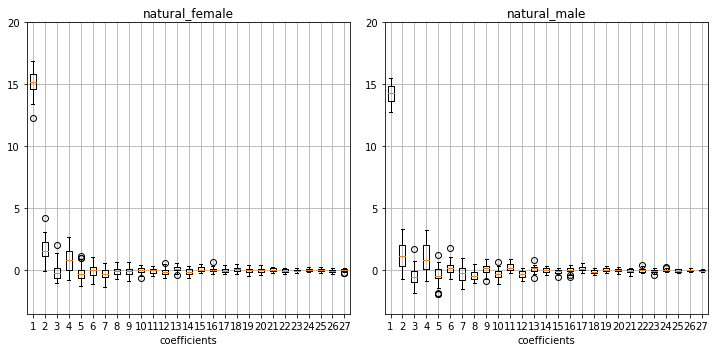

In [48]:
util.print_coeff_boxplot(['natural_male', 'natural_female'], FILES, nceps=MFCC_COEFFS)

### Model complexity and learning duration

In order to choose the correct learning duration and the modely complexity, we iterate over the number of epochs (EPOCHS) and number of hidden neurons (N_NEURONS).

This step will help us choose the best combination of thoses parameters trying to maximize the accuracy (with a lower MSE) and minimize the computation time (less complexity and less iterations).

In [87]:
EPOCHS = 1000
N_NEURONS = [2, 3, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.6

K = 4
N_INITS = 4

testing 2 neurons...


testing 3 neurons...


testing 8 neurons...


testing 16 neurons...


testing 32 neurons...


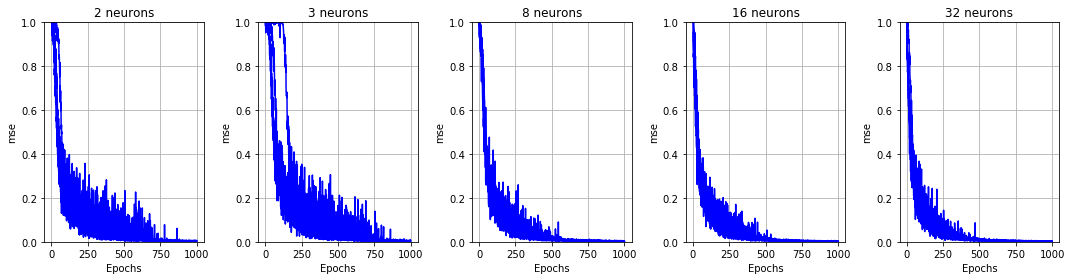

In [75]:
dataset = util.create_dataset([('natural_male', -1), ('natural_female', 1)], FILES, MFCC_COEFFS)
dataset_input = dataset[:, :-1]     # filter only input values (n-1 first values)
dataset_output = dataset[:, -1:]    # filter only the output class (last value)

MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))
for index, n_neurons in enumerate(N_NEURONS):
    print 'testing', n_neurons, 'neurons...'
    nn = MLP([MFCC_COEFFS, n_neurons, 1], 'tanh')

    for i in np.arange(N_INITS):
        nn.init_weights()
        MSE[index, i, :] = nn.fit((dataset_input, dataset_output),
                                  learning_rate=LEARNING_RATE,
                                  momentum=MOMENTUM,
                                  epochs=EPOCHS)

util.print_mse(MSE, N_NEURONS)

From 2 to 8 neurons in the hidden layer, we observe oscillations in the training error. This was due unlucky initializations of the MLPs.
But in all cases from 2 to 32 neurons the error does not improve much after 600 EPOCHS. This test indicate that the minimum number of iterations needed are around 600-700.

Testing 2 neurons...


Testing 3 neurons...


Testing 8 neurons...


Testing 16 neurons...


Testing 32 neurons...


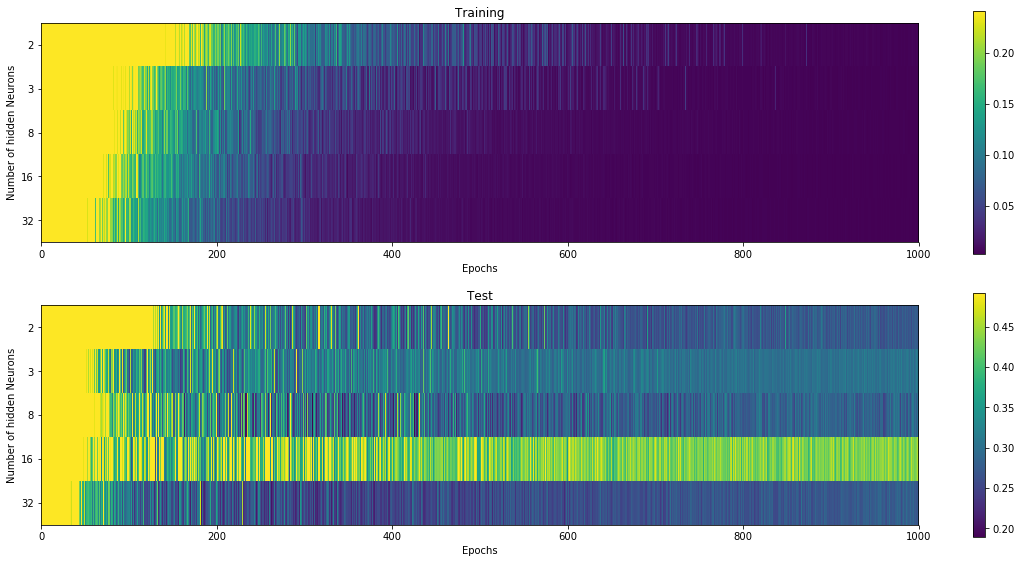

In [88]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS))


dataset = util.create_dataset([('natural_male', -1), ('natural_female', 1)], FILES, MFCC_COEFFS)

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print 'Testing', h, 'neurons...'
    nn = MLP([MFCC_COEFFS, h, 1], 'tanh')
    temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,
                                                        dataset,
                                                        k=K,
                                                        learning_rate=LEARNING_RATE,
                                                        momentum=MOMENTUM,
                                                        epochs=EPOCHS)
    MSE_train[i_h, :] = temp1
    MSE_test[i_h, :] = temp2


# print results
util.print_mse_train_test(MSE_train, MSE_test, N_NEURONS, aspect=50)

This test indicates that using more neurons allows us to reduce the number of iterations. And in the case of 32 neurons in the hidden layer, training the algorithm for more that 600 iterations doesn't improve the prediction. To avoid using too much resources we should run the backpropagation algorithm using 600 EPOCHS. 

### Performance of the final model

An artificial neural network with 32 neurons and 600 iteration of the backpropagation algorithm is enough to recognize the gender of the speaker with a good precision. 

In [90]:
EPOCHS = 600
N_NEURONS = 32
LEARNING_RATE = 0.001
MOMENTUM = 0.6
K = 4

precision:	0.959
recall:	0.958
f1_score:	0.958
MSE training:	0.00341638470774
MSE test:	0.1675860248
Confusion matrix:
[[ 35.   1.]
 [  2.  34.]]


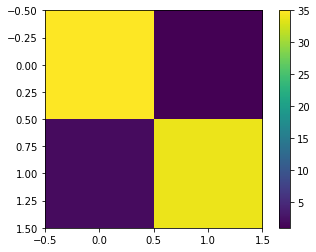

In [72]:
nn = MLP([MFCC_COEFFS, N_NEURONS, 1], 'tanh')
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                           dataset,
                                                           k=K,
                                                           learning_rate=LEARNING_RATE,
                                                           momentum=MOMENTUM,
                                                           epochs=EPOCHS,
                                                           threshold=0.0)


precision, recall, f1_score = util.conf_mat_stats(conf_mat)
print "precision:\t", np.round(precision, 3)
print "recall:\t",    np.round(recall, 3)
print "f1_score:\t",  np.round(f1_score, 3)
print 'MSE training:\t', MSE_train
print 'MSE test:\t', MSE_test
print 'Confusion matrix:'
pl.imshow(conf_mat)
pl.colorbar()
print conf_mat